# Check spike spatial variation

author: steeve.laquitaine@epfl.ch


* `534` near-contact cells
* `472` pyramidal cells


In [76]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)
from src.nodes.postpro import waveform
from src.nodes.utils import get_config, write_metadata
from src.nodes.truth.silico import ground_truth
from src.nodes.io.silico.loading import load_campaign_params
from src.nodes.dataeng.silico import probe_wiring

# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"    # specifies the experiment 
SIMULATION_DATE = "2023_02_19" # specifies the run (date)
MS_BEFORE = 3       # ms
MS_AFTER = 3        # ms
CELL_ID = 4229506   # the most active near-probe pyramidal cell
CHANNEL_IDS = np.arange(64,80).tolist()   # plot traces from channels nearest to filtered neuron group

# SETUP CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SETUP PATH
SPIKE_FILE_PATH = data_conf["dataeng"]["campaign"]["output"]["spike_file_path"]
RAW_LFP_TRACE_FILE_PATH = data_conf["dataeng"]["campaign"]["output"]["trace_file_path"]
CELL_TRACE_FILE_PATH = data_conf["dataeng"]["campaign"]["output"]["unit_trace_path"]+"cell_3754013_trace.pkl"


# SET WAVEFORM FOLDER
STUDY_FOLDER = data_conf["postprocessing"]["waveform"]["study"]


# FIGURE
FIG_PATH = data_conf["figures"]["silico"]["spike_spatial_variation"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-03-03 13:59:08,916 - root - utils.py - get_config - INFO - Reading experiment config.
2023-03-03 13:59:08,968 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Check spike SNR and consistency 

1. We preprocess the raw LFP traces
2. We extract the waveforms within -3 to 3 ms centered on the spike timestamps of the most active pyramidal to have a large enough spike sample size.
3. We plot the spike-triggered average of each contact
4. We plot the neuron and contact locations associated with each spike triggered average

In [7]:
# Preprocess traces and extract spikes (stats: 110 min for a 10 min campaign, 534 near-contact cells)
WaveformExtractor = waveform.run_from_files(
    experiment=EXPERIMENT,
    simulation_date=SIMULATION_DATE,
    lfp_trace_file=RAW_LFP_TRACE_FILE_PATH,
    spike_file=SPIKE_FILE_PATH,
    study_folder=STUDY_FOLDER,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER
    )

2023-03-03 11:10:37,456 - root - utils.py - get_config - INFO - Reading experiment config.
2023-03-03 11:10:37,476 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-03-03 12:57:36,989 - root - probe_wiring.py - run_neuropixels_32 - INFO - casting raw traces as SpikeInterface Recording object ...
2023-03-03 12:58:22,113 - root - probe_wiring.py - run_neuropixels_32 - INFO - casting as raw traces as SpikeInterface Recording object - done in 45.1
2023-03-03 12:58:22,116 - root - probe_wiring.py - run_neuropixels_32 - INFO - reconstructing neuropixels-32 probe ...
2023-03-03 12:59:11,144 - root - probe_wiring.py - run_neuropixels_32 - INFO - reconstructing neuropixels-32 probe - done in 49.0
2023-03-03 12:59:11,147 - root - probe_wiring.py - run_neuropixels_32 - INFO - wiring neuropixels-32 probe to recording - done
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


`Result: The spike waveforms of an example active pyramidal cell within 50 microns of a probe contact (green lines), overlaid on a spike triggered average plot, are clearly visible (above background noise) and consistent over time.`

## Get near-contact pyramidal cells

In [8]:
# get near-contact pyramidal cells (stats: 2 min)
simulation = load_campaign_params(data_conf)

# (stats: 60 to 100 min for 534 cells near the contacts, when first created)
if not os.path.isdir(data_conf["sorting"]["simulation"]["ground_truth"]["output"]):
    SortingExtractor = ground_truth.run(simulation_params, data_conf, param_conf)
    SortingExtractor = SortingExtractor["ground_truth_sorting_object"]
else:
    SortingExtractor = ground_truth.load(data_conf)

cell_morph = simulation["circuit"].cells.get(SortingExtractor.unit_ids, properties=['morph_class'])
CELL_IDS = cell_morph[cell_morph["morph_class"] == "PYR"].index.values
print("near-contact pyr. cells (count): ", len(CELL_IDS))

2023-03-03 13:31:40,665 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-03-03 13:31:40,680 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0
near-contact pyr. cells (count):  472


In [26]:
# WARNIN !! for each pyramidal cell (very slow takes 1h-ish)
for cell_i in CELL_IDS:
    
    # compute waveform plot
    fig = waveform.plot(WaveformExtractor=WaveformExtractor, cell_id=cell_i)

    # write
    if not os.path.isdir(f"{FIG_PATH}pyramidal/"):
        os.makedirs(f"{FIG_PATH}pyramidal/")
    fig.savefig(f"{FIG_PATH}pyramidal/cell_{cell_i}", dpi=300, bbox_inches='tight')

# show
# plt.show()

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/waveform.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(3, 3))


## Check spike spatial variation

`Result: The spike waveforms are most visible on channel (71) on which it has maximum positive and negative amplitudes and nearby channels (72,73,74) in agreement with its estimated location on channel 72, rightward to channel 71.`

In [15]:
# fig = waveform.plot_by_channel(WaveformExtractor, channel_ids=CHANNEL_IDS, cell_id=CELL_ID, figsize=(2,35))
# print("cell's waveforms (green) and its median (Fuchsia) by channel (pannels)")

In [77]:
# get chosen cell's coordinate
cell_coord = simulation["circuit"].cells.get(CELL_ID, properties=["x","y","z"])
print("cell coordinates:\n", cell_coord)

# wire the recording with its probe and get the probe's contact coordinates
recording = probe_wiring.run(data_conf, param_conf)
probe_wiring.write(recording, data_conf)
probe = recording.get_probe()
probe_coord = probe.contact_positions.astype(float)
print("contact x-y coordinates:\n", probe_coord[:,:1])

cell coordinates:
 x    4071.212207
y   -1273.451867
z   -2338.888698
Name: 4229506, dtype: float64
2023-03-03 13:59:27,655 - root - probe_wiring.py - run_neuropixels_32 - INFO - casting raw traces as SpikeInterface Recording object ...
2023-03-03 13:59:50,835 - root - probe_wiring.py - run_neuropixels_32 - INFO - casting as raw traces as SpikeInterface Recording object - done in 23.2
2023-03-03 13:59:50,836 - root - probe_wiring.py - run_neuropixels_32 - INFO - reconstructing neuropixels-32 probe ...
2023-03-03 14:00:17,793 - root - probe_wiring.py - run_neuropixels_32 - INFO - reconstructing neuropixels-32 probe - done in 27.0
2023-03-03 14:00:17,795 - root - probe_wiring.py - run_neuropixels_32 - INFO - wiring neuropixels-32 probe to recording - done
write_binary_recording with n_jobs = 1 and chunk_size = None
2023-03-03 14:00:36,362 - root - probe_wiring.py - write - INFO - Probe wiring done in  18.0 secs
2023-03-03 14:00:36,363 - root - probe_wiring.py - write - INFO - Probe wirin

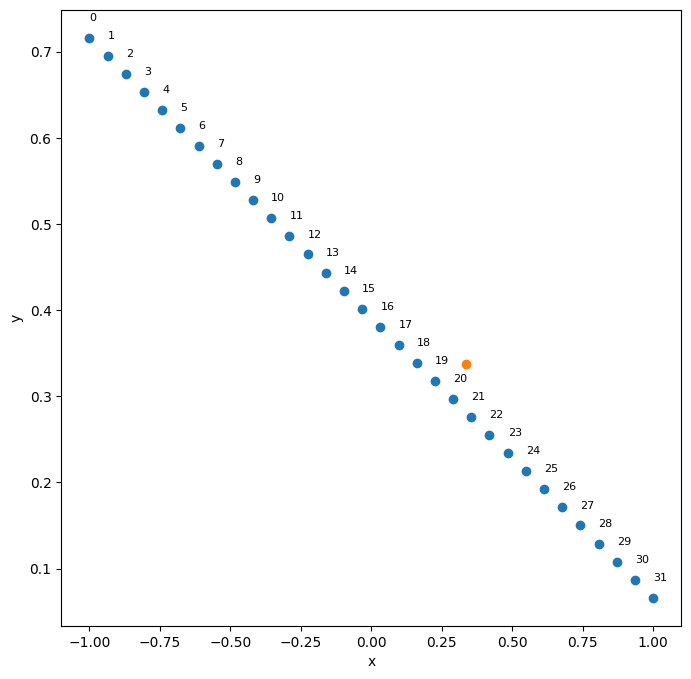

In [78]:
# scale coordinates linearly between -1 and 1 for plot (0 being the cell coordinates)
norm_contact_coord = np.subtract(probe_coord[:,:2], cell_coord.values[:2])
ncc = norm_contact_coord
ncc_max = norm_contact_coord.max().max()
ncc_min = norm_contact_coord.min().min()
scaled_contact_coord = (ncc-ncc_min)/(ncc_max-ncc_min)*2-1

# normalize cell
norm_cell_coord = np.array([0,0])
scaled_cell_coords = (norm_cell_coord - ncc_min)/(ncc_max-ncc_min)*2-1

# plot
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(scaled_contact_coord[:,0], scaled_contact_coord[:,1], "o");
ax.plot(scaled_cell_coords[0], scaled_cell_coords[1], "o");
ax.set_xlabel("x");
ax.set_ylabel("y");

contact_ids = probe.device_channel_indices

# annotate contacts with their ids
for ix in range(len(probe_coord)):
    ax.text(
        scaled_contact_coord[ix, 0],
        scaled_contact_coord[ix, 1]+0.02,
        "%s" % (str(contact_ids[ix])),
        size=8,
        zorder=1,
        color="k",
    )

In [89]:
# print(WaveformExtractor.sorting.unit_ids)
spike_count = SortingExtractor.get_total_num_spikes()[4229506] 
cell_firing_rate = SortingExtractor.get_total_num_spikes()[4229506] / 500
print(cell_firing_rate)
print(spike_count)

0.624
312


In [79]:
# get chosen cell's coordinate
CELL_ID = 4229506
cell_coord = simulation["circuit"].cells.get(CELL_ID, properties=["x","y","z"])
print("cell coordinates:\n", cell_coord)

cell coordinates:
 x    4071.212207
y   -1273.451867
z   -2338.888698
Name: 4229506, dtype: float64


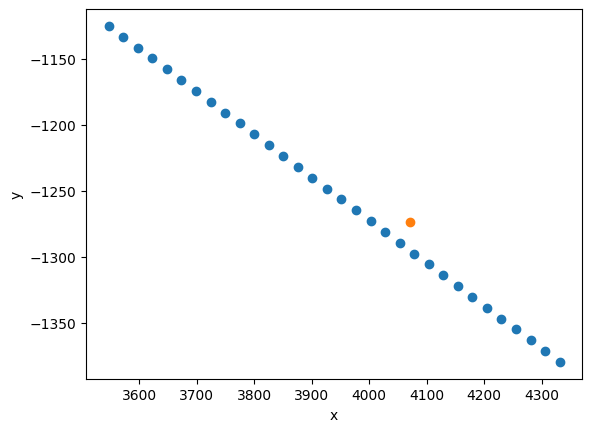

In [80]:
# test that the euclidean distances are preserved compared to the raw coordinates
plt.plot(probe_coord[:,0], probe_coord[:,1], "o");
plt.plot(cell_coord.x, cell_coord.y, "o");
plt.xlabel("x");
plt.ylabel("y");

TODO:
- Color each trace by its peak to peak amplitude (like in `Buszaki, Koch, Journal of Neuroscience`)

contacts (numbers), median spike (lines), pyramidal cell (red dot). The contacts are located at the center of each spike panel.
channels (color)


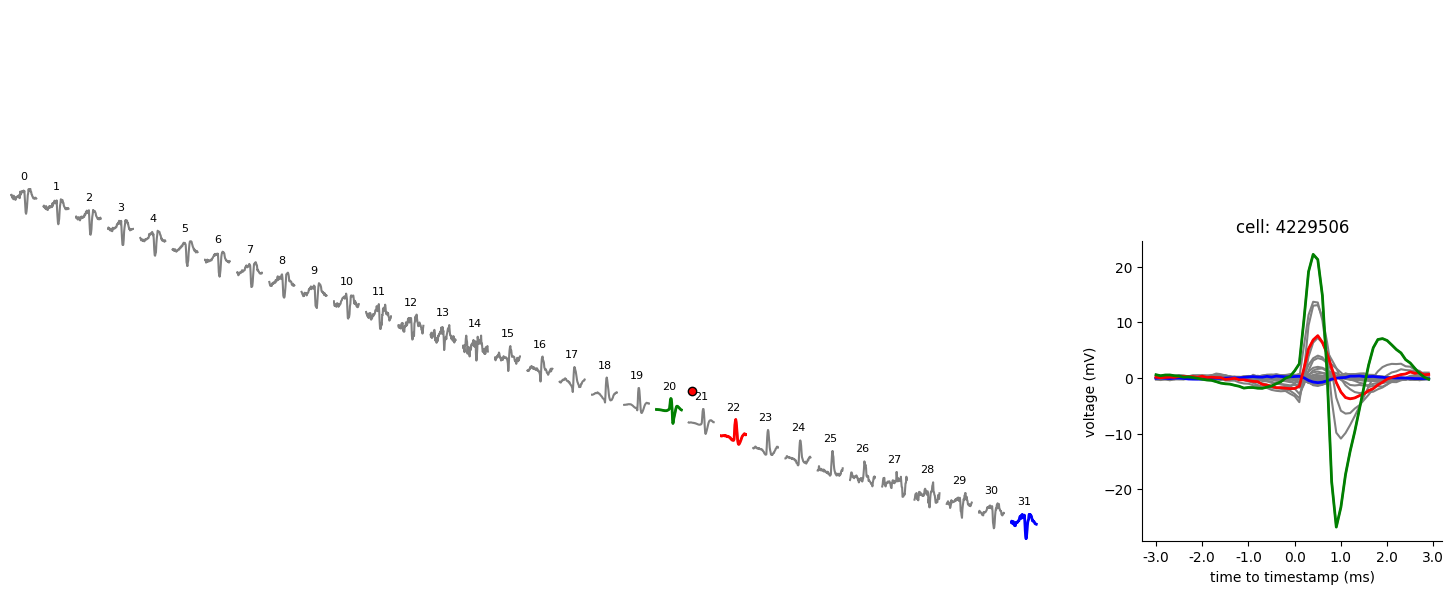

In [83]:
# setup plot
fig = plt.figure(figsize=(5,5));

# Plot spatial variation
# --------------------
# create plane and panel parameters
x_y_plane = [0.1, 0.1, 1, 1]
panel_width = 0.055

# plot x-y-plane
ax = fig.add_axes(x_y_plane);
ax.axis('off');

# plot cell panel in the x-y plane
coord_cell_panel = [scaled_cell_coords[0]-panel_width/2, scaled_cell_coords[1]-panel_width/2, panel_width, panel_width]
ax0 = fig.add_axes(coord_cell_panel)
ax0.plot(0.0, marker="o", markerfacecolor="r", markeredgecolor="k");
ax0.axis('off');

median_spike = WaveformExtractor.get_template(unit_id=CELL_ID, mode='median');

DISTANT_CHANNEL = 31
NEARBY_CHANNEL_RIGHT = 20
NEARBY_CHANNEL_LEFT = 22

# plot each contact's average spike panel in the x-y plane
for ix in range(len(scaled_contact_coord)):
    
    # center each panel on the associated contact coordinate
    coord_contact_i = [scaled_contact_coord[ix,0]-panel_width/2, scaled_contact_coord[ix,1]-panel_width/2, panel_width, panel_width]

    # contact
    ax0 = fig.add_axes(coord_contact_i)
    ax0.plot(median_spike[:,ix], color=[.5, .5, .5]);
    if ix == DISTANT_CHANNEL:
        ax0.plot(median_spike[:,ix], color="b", linewidth=2);
    if ix == NEARBY_CHANNEL_LEFT:
        ax0.plot(median_spike[:,ix], color="r", linewidth=2);
    if ix == NEARBY_CHANNEL_RIGHT:
        ax0.plot(median_spike[:,ix], color="g", linewidth=2);
    ax0.axis('off');
    ax0.set_title(ix, fontsize=8)

print("contacts (numbers), median spike (lines), pyramidal cell (red dot). The contacts are located at the center of each spike panel.")

# get unit waveforms (n_spikes, n_sample, n_channels)
wfs = WaveformExtractor.get_waveforms(CELL_ID);

# plot unit median waveforms by channel on the same level as the cell's y-axis
# to see spike amplitude difference
panel_width = 0.6
panel_offset = 1.2
x_y_plane2 = [scaled_cell_coords[0]-panel_width/2 + panel_offset, scaled_cell_coords[1]-panel_width/2, panel_width, panel_width]
ax1 = fig.add_axes(x_y_plane2);
median_spike = WaveformExtractor.get_template(unit_id=CELL_ID, mode='median');
ax1.plot(median_spike, color=[.5, .5, .5]);
ax1.plot(median_spike[:, DISTANT_CHANNEL], color="b", linewidth=2);
ax1.plot(median_spike[:, NEARBY_CHANNEL_LEFT], color="r", linewidth=2);
ax1.plot(median_spike[:, NEARBY_CHANNEL_RIGHT], color="g", linewidth=2);

ms_timestep = 6 / median_spike.shape[0]
x_ticklabels = np.arange(-ms_timestep * median_spike.shape[0]/2, ms_timestep * median_spike.shape[0]/2 + 1)
ms_timestep = 1/simulation["lfp_sampling_freq"]*1000
x_ticks = np.arange(0, median_spike.shape[0]+1, 1/ms_timestep)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_ticklabels)
ax1.set_xlabel("time to timestamp (ms)")
ax1.set_ylabel("voltage (mV)")

ax1.spines[['right', 'top']].set_visible(False)
ax1.set_title(f'cell: {CELL_ID}');
print("channels (color)")

In [ ]:

# # cell_coord
# # probe_coord[:,16]

# # calculate euclidean distance b/w cells and channel contacts
# nearest_channel = []
# for c_i, cell_i in enumerate(cell_coord.index):
#     channel_dist = []
#     for ch_i in range(probe_coord.shape[0]):
#         channel_dist.append(scipy.spatial.distance.euclidean(cell_coord.iloc[c_i], probe_coord[ch_i, :]))
#     nearest_channel.append(np.argmin(np.array(channel_dist)))
# nearest_channel_series = pd.Series(data=nearest_channel, index=cell_coord.index)

# # get_most_active_cell()

In [64]:
# TODO:
# - I do a screenshot for now, but need to implement automatic saving

# # save figure
# fig.savefig(FIG_PATH+".png")

# # write metadata
# metadata = {
#     "fig_path": FIG_PATH,
#     "creation_date": datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
#     "simulation_date": SIMULATION_DATE,
#     "data_conf": data_conf,
#     "param_conf": param_conf,
#     }
# write_metadata(metadata, FIG_PATH)